In [7]:
import tifffile as tiff
import numpy as np
from dbfread import DBF
from matplotlib import pyplot
import matplotlib.patches as mpatches
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, concatenate, Dropout, Input, Reshape,BatchNormalization, MaxPooling2D, UpSampling2D, ReLU, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [2]:
#look at labels
for record in DBF('CDL_2013_clip_20170525181724_1012622514.tif.vat.dbf'):
    if 'Corn' in record['CLASS_NAME']:
        print(record)
    if 'Soybean' in record['CLASS_NAME']:
        print(record)

OrderedDict([('VALUE', 1), ('CLASS_NAME', 'Corn'), ('RED', 1.0), ('GREEN', 0.82745098039), ('BLUE', 0.0), ('OPACITY', 1.0)])
OrderedDict([('VALUE', 5), ('CLASS_NAME', 'Soybeans'), ('RED', 0.14901960784), ('GREEN', 0.43921568628), ('BLUE', 0.0), ('OPACITY', 1.0)])
OrderedDict([('VALUE', 12), ('CLASS_NAME', 'Sweet Corn'), ('RED', 0.86666666667), ('GREEN', 0.64705882353), ('BLUE', 0.04705882353), ('OPACITY', 1.0)])
OrderedDict([('VALUE', 13), ('CLASS_NAME', 'Pop or Orn Corn'), ('RED', 0.86666666667), ('GREEN', 0.64705882353), ('BLUE', 0.04705882353), ('OPACITY', 1.0)])
OrderedDict([('VALUE', 26), ('CLASS_NAME', 'Dbl Crop WinWht/Soybeans'), ('RED', 0.43921568628), ('GREEN', 0.43921568628), ('BLUE', 0.0), ('OPACITY', 1.0)])
OrderedDict([('VALUE', 225), ('CLASS_NAME', 'Dbl Crop WinWht/Corn'), ('RED', 1.0), ('GREEN', 0.82745098039), ('BLUE', 0.0), ('OPACITY', 1.0)])
OrderedDict([('VALUE', 226), ('CLASS_NAME', 'Dbl Crop Oats/Corn'), ('RED', 1.0), ('GREEN', 0.82745098039), ('BLUE', 0.0), ('OPAC

In [3]:
# Using 3 classes
# Labels like 'Sweet corn' are classified as other b/c of insignificant presence
# just as a reminder
classname = {
    0: 'corn',
    1: 'soybeans',
    2: 'other'
}

In [16]:
# load data and label
label = tiff.imread('CDL_2013_Champaign_north.tif')
data = tiff.imread('20130824_RE3_3A_Analytic_Champaign_north.tif')
print(label.shape)
print(data.shape)

# reformat label into 3 classes
print(np.unique(label, return_counts=True))
label[label == 1] = 0
label[label == 5] = 1
label[label > 1] = 2
print(np.unique(label, return_counts=True))

(5959, 9425)
(5959, 9425, 5)
(array([  1,   4,   5,  12,  13,  24,  26,  27,  28,  36,  37,  43,  58,
        59,  61, 111, 121, 122, 123, 124, 131, 141, 152, 176, 190, 195,
       222, 225, 241, 254], dtype=uint8), array([25320079,       91, 21417646,       49,      175,   347273,
          11531,       98,     5822,    80493,    74592,     3319,
            570,      406,     2299,   154704,  2325753,  1977922,
         375668,   124415,    23416,  1287172,      680,  2522307,
         105601,      680,      189,      176,      407,       42],
      dtype=int64))
(array([0, 1, 2], dtype=uint8), array([25320079, 21417646,  9425850], dtype=int64))


In [17]:
# reformat into 128*128
x_train = []
y_train = []
x = 0
while x < label.shape[0] - 128:
    y = 0
    while y < label.shape[1] - 128:
        x_train.append(data[x:x + 128, y:y + 128,:])
        y_train.append(label[x:x + 128, y:y + 128])
        y += 128
    x += 128
x_train = np.array(x_train)
y_train = np.array(y_train)

# sanity check
print(int(label.shape[0]/128) * int(label.shape[1]/128))
print(x_train.shape)
print(y_train.shape)

3358
(3358, 128, 128, 5)
(3358, 128, 128)


In [18]:
#drop training entry with all 0s (approximatly 200 img)
x_cleaned = [x for x, y in zip(x_train,y_train) if x.any() != 0]
y_cleaned = [y for x, y in zip(x_train,y_train) if x.any() != 0]
X = np.array(x_cleaned)
y = np.array(y_cleaned)

#train test split
arr_rand = np.random.rand(X.shape[0])
split = arr_rand < np.percentile(arr_rand, 90)

x_train = X[split]
y_train = y[split]
x_test =  X[~split]
y_test = y[~split]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(2993, 128, 128, 5) (2993, 128, 128) (333, 128, 128, 5) (333, 128, 128)


In [23]:

# unet model
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)
    model = Model(input_img, outputs)
    model.summary()
    return model

In [94]:
input_img = Input((128, 128, 5), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 5) 0                                            
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 128, 128, 16) 736         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_86 (BatchNo (None, 128, 128, 16) 64          conv2d_115[0][0]                 
__________________________________________________________________________________________________
re_lu_83 (ReLU)                 (None, 128, 128, 16) 0           batch_normalization_86[0][0]     
____________________________________________________________________________________________

In [104]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
]

In [105]:
# train with adam * two callbacks(early stop + reduce lr)
model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 50,
    validation_data = [x_test, y_test],
    callbacks = callbacks
)

Train on 2993 samples, validate on 333 samples
Epoch 1/50
2993/2993 [==============================] - 32s 11ms/sample - loss: 0.3678 - accuracy: 0.8621 - val_loss: 0.9594 - val_accuracy: 0.6143
Epoch 2/50
2993/2993 [==============================] - 28s 9ms/sample - loss: 0.3447 - accuracy: 0.8700 - val_loss: 0.9665 - val_accuracy: 0.5862
Epoch 3/50
2993/2993 [==============================] - 28s 9ms/sample - loss: 0.3204 - accuracy: 0.8781 - val_loss: 0.7264 - val_accuracy: 0.6651
Epoch 4/50
2993/2993 [==============================] - 28s 9ms/sample - loss: 0.3185 - accuracy: 0.8795 - val_loss: 0.4512 - val_accuracy: 0.8121
Epoch 5/50
2993/2993 [==============================] - 28s 9ms/sample - loss: 0.3045 - accuracy: 0.8842 - val_loss: 0.3999 - val_accuracy: 0.8589
Epoch 6/50
2993/2993 [==============================] - 28s 9ms/sample - loss: 0.2964 - accuracy: 0.8869 - val_loss: 0.3092 - val_accuracy: 0.8818
Epoch 7/50
2993/2993 [==============================] - 28s 9ms/sample

In [19]:
model.evaluate(x_test, y_test)

333/333 [==============================] - 87s 261ms/sample - loss: 0.2424 - accuracy: 0.9057


[0.24243013609994998, 0.9057133]

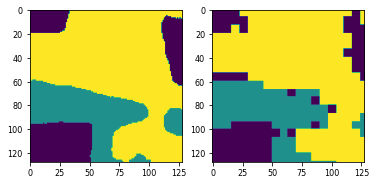

In [130]:
# have model predict an image
out = model.predict(x_test[233:234])
out = np.argmax(out[0], axis=2)
pyplot.subplot(1,2,1)
pyplot.imshow(out)
pyplot.subplot(1,2,2)
pyplot.imshow(y_test[233])

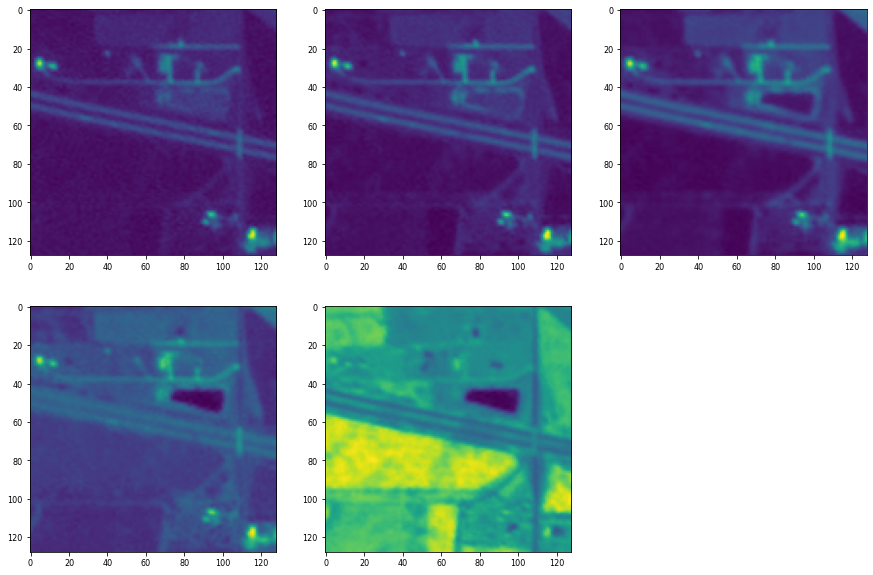

In [147]:
# see original image
pyplot.figure(figsize=(15,10))
for i in range(0,5):
    pyplot.subplot(2,3,i+1)
    pyplot.imshow(x_test[233,...,i])

In [2]:
validation = tiff.imread('20130824_RE3_3A_Analytic_Champaign_south.tif')
print(validation.shape)
# reformat into 128*128
x_val = []
x = 0
while x < validation.shape[0] - 128:
    y = 0
    while y < validation.shape[1] - 128:
        x_val.append(validation[x:x + 128, y:y + 128,:])
        y += 128
    x += 128
x_val = np.array(x_val)
print(x_val.shape)

(5959, 9425, 5)
(3358, 128, 128, 5)


In [3]:
model = tf.keras.models.load_model('cleaned_dataset')
y_val = model.predict(x_val)
y_decode = y_val.argmax(axis = 3)

In [4]:
combined = np.zeros((int(5959/128) * 128, int(9425/128) * 128))
x = 0
index = 0
while x < combined.shape[0]:
    y = 0
    while y < combined.shape[1]:
        combined[x:x + 128, y:y + 128] = y_decode[index]
        y += 128
        index += 1
    x += 128
x_val = np.array(x_val)

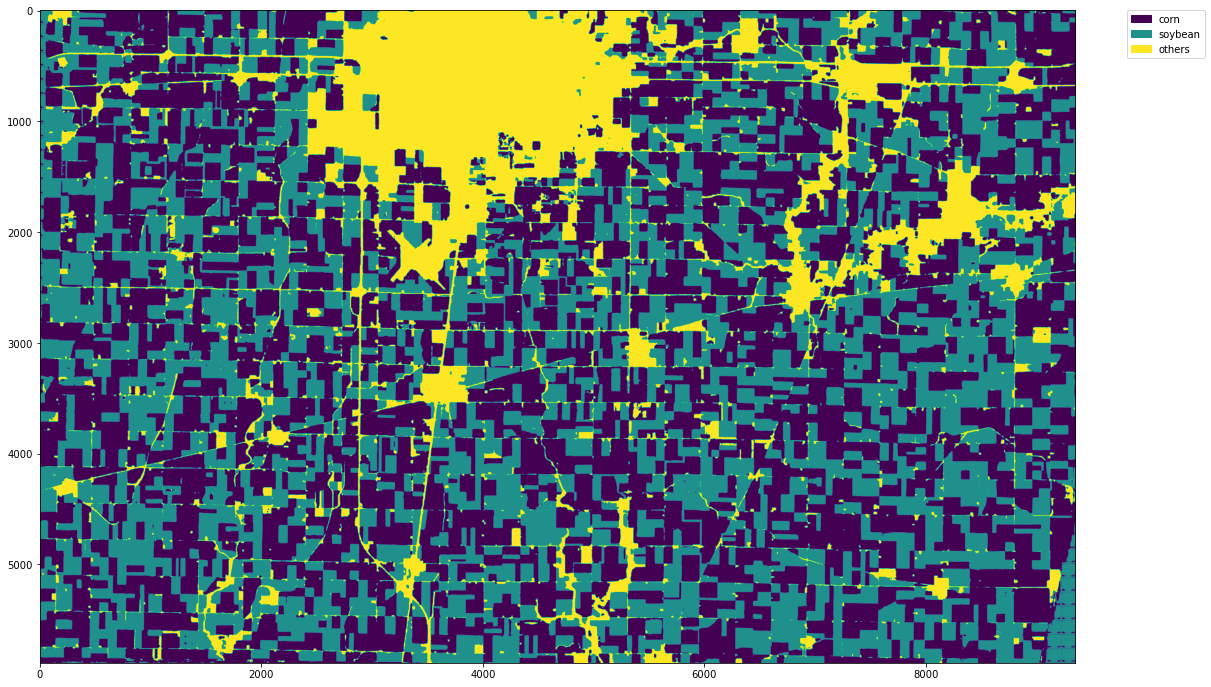

In [12]:
pyplot.figure(figsize = (20, 12))
im = pyplot.imshow(combined)

values = np.unique(combined)
colors = [im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label=j) for i,j in zip(range(len(values)), ['corn', 'soybean', 'others']) ]
pyplot.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

pyplot.show()

In [15]:
pyplot.imsave('south_unet_with_cleaned_data.png', combined)